<a href="https://colab.research.google.com/github/2325247/aula-medchem/blob/main/Aula1_Obten%C3%A7%C3%A3o_de_dados_do_ChEMBL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Objetivos dessa aula

Nessa aula aprenderemos mais sobre o banco de dados do ChEBML e como extrair suas informações. Especificamente dados de estrutura e atividade de moléculas testadas em um alvo de intresse. Esse conjunto de dados será usado posteriormente em diversas atividades, como busca por similaridade, aprendizado de máquina e docking.

### 1.1) Conteúdos práticos
    
**Objetivo: Obter uma lista de compostos com dados de bioatividade para um determinado alvo macromolecular**

* Utilizando o website do ChEMBL
* Obter dados do composto
    * Preprocessamento e filtragem
* Output dos dados de bioatividade-composto
    * Merge bioactivity and compound data, and add pIC50 values
    * Draw molecules with highest pIC50
    * Write output file

### 1.2) Referências

* ChEMBL bioactivity database: [Gaulton *et al.*, <i>Nucleic Acids Res.</i> (2017), 45(Database issue), D945–D954](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5210557/)
* The EBI RDF platform: [Jupp *et al.*, <i>Bioinformatics </i> (2014), 30(9), 1338-9](https://www.ncbi.nlm.nih.gov/pubmed/24413672)
* Info on half maximal inhibitory concentration: [pIC50](https://en.wikipedia.org/wiki/IC50)
* [UniProt website](https://www.uniprot.org/)

## 2) Teoria

### ChEMBL database
>"ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs." ([ChEMBL website](https://www.ebi.ac.uk/chembl/))

* Conjunto de dados de biotividade em larga escala com open-acess
* **Conjunto atual de dados (em 09.2020, ChEMBL 27):**
    * \>1.9 milhões de compostos distindos
    * \>16 milhões de valores de atividades
    * Ensaios em ~13,000 alvos
* A **origem dos dados** incluí literatura científica, ensaios do PubChem, DNDi, BindingDB...
* ChEMBL data can be accessed via a [web-interface](https://www.ebi.ac.uk/chembl/), the [EBI-RDF platform](https://www.ncbi.nlm.nih.gov/pubmed/24413672) and the [ChEMBL web rescource client](https://github.com/chembl/chembl_webresource_client)

## 3) Atividade prática


Em sequência, utilizaremos o ChEMBL para obter todas as moléculas que foram testadas contra o nosso alvo de interesse, a  **epidermal growth factor receptor** ([**EGFR**](https://www.uniprot.org/uniprot/P00533)) kinase.

* Uniprot ID: EGFR kinase:  [P00533](http://www.uniprot.org/uniprot/P00533))
* Use o UniProt ID para obter informações sobre o alvo no site do [ChEMBL](https://www.ebi.ac.uk/chembl/)

Buscar pelo Type **SINGLE PROTEIN** do organismo *Homo sapiens*

Filtrar os resultados:

Standard Type = **"IC50"**, Standard Relation = **"="**, Assay Data Type Label = **"B"**, Standard Value = **"nM"**

### 3.1) Montando o gdrive e importando bibliotecas importantes

Nessa etapa será necessário associar o seu google drive ao seu notebook do colab. Para tanto rode a célula abaixo e quando solicitado realize o login no Google Drive, onde serão baixados os arquivos necessários.

https://drive.google.com/drive/folders/1U7g-vXBwnzpBiVl3uCnk6rjVVUX72py_?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install rdkit

In [182]:
import pandas as pd
import math
import rdkit.Chem as Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import PandasTools, Descriptors, Draw
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

from tqdm.auto import tqdm

In [ ]:
def standardize(smiles):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    params = Chem.SmilesParserParams()
    params.isomericSmiles = True
    params.allBondsExplicit=True
    mol = Chem.MolFromSmiles(smiles, params=params)
    mol.UpdatePropertyCache(strict=False)
    Chem.SanitizeMol(mol,sanitizeOps=(Chem.SANITIZE_ALL^Chem.SANITIZE_CLEANUP^Chem.SANITIZE_PROPERTIES))
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)
    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
    Chem.AssignStereochemistryFrom3D(uncharged_parent_clean_mol)

        # Generate canonical SMILES
    canonical_smiles = Chem.MolToSmiles(uncharged_parent_clean_mol, isomericSmiles=True, canonical=True)

    return canonical_smiles

In [ ]:
PandasTools.RenderImagesInAllDataFrames(images=True)

### 3.2) Obter os dados relacionados ao alvo (EGFR kinase)

In [ ]:
#Carregar o arquivo baixado no ChEMBL
df = pd.read_csv('https://raw.githubusercontent.com/2325247/aula-medchem/main/cheminformatics/DATA/activity_data_EGFR.csv', delimiter=';')

In [ ]:
#Ver as 5 primeiras linhas do dataframe e conferir se os dados estão corretos.
df.head(5)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL288441,BOSUTINIB,4.0,530.46,2,5.19,SKI-606,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1240341,1,Scientific Literature,Leukemia,2009.0,None,NaN,NaN
1,CHEMBL271410,NaN,None,378.48,0,3.21,"126, page S27 table 1",Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1143196,1,Scientific Literature,J Med Chem,2008.0,None,NaN,NaN
2,CHEMBL411243,NaN,None,429.37,0,4.67,"109, page S26 table 1",CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1143196,1,Scientific Literature,J Med Chem,2008.0,None,NaN,NaN
3,CHEMBL270713,NaN,None,387.29,0,3.50,"106, page S26 table 1",CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1143196,1,Scientific Literature,J Med Chem,2008.0,None,NaN,NaN
4,CHEMBL54475,NaN,None,301.15,0,3.53,"78, page S25 table 1",Brc1cccc(Nc2ncnc3ncccc23)c1,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1143196,1,Scientific Literature,J Med Chem,2008.0,None,NaN,NaN


In [ ]:
#Vamos manter apenas as colunas que possuem relevância para as próximas etapas do nosso trabalho.

colunas = ['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']

#Criando um novo dataframe apenas com as informações relevantes

bioactivities_df = df[colunas]

In [ ]:
#Checando

bioactivities_df.head(5)

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
0,CHEMBL288441,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,IC50,'=',491.000,nM
1,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,IC50,'=',9.333,nM
2,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,IC50,'=',8.511,nM
3,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,IC50,'=',45.710,nM
4,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,IC50,'=',691.830,nM


In [ ]:
#Verificando as dimensões do dataframe atual

print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (10924, 6)


### 3.3) Preprocessamento e filtragem inicial dos dados.

#### **3.3.a) Deletar linhas faltando valores**

In [ ]:
bioactivities_df = bioactivities_df.dropna(axis=0, how="any")

print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (10916, 6)


#### **3.3.b) Deletar moléculas duplicadas**

Em alguns casos uma mesma moléculas (`Molecule ChEMBL ID`) foi testada mais de uma vez, nestes casos mantemos a primeira ocorrência.

In [ ]:
bioactivities_df.drop_duplicates("Molecule ChEMBL ID", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (7060, 6)


#### **3.3.c) Resetar o index do "DataFrame"**

Como algumas linhas foram deletadas, precisamos resetar os índice para atualizar a numeraçã oe ele se manter continuo (Isso é importante para que não ocorram erros nas próximas etapas do processamento).

In [ ]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (7060, 6)


Agora temos **7060** moleculas com respectivos valores de IC50 para a nossa kinase alvo.

#### **3.3.d) Sanitizando as moléculas e gerando SMILES canônicos**

In [ ]:
# Apply the standardize function to the 'Smiles' column and create a new column 'Canonical_Smiles'
bioactivities_df['Canonical_Smiles'] = bioactivities_df['Smiles'].apply(lambda x: standardize(x))

#Drop Smiles Column

temp = bioactivities_df.drop(columns=['Smiles'])

# Delete duplicates in the Canonical_Smiles
temp.drop_duplicates("Canonical_Smiles", keep="first", inplace=True)

# Reset index
temp.reset_index(drop=True, inplace=True)

#Change column order
col = ['Molecule ChEMBL ID', 'Canonical_Smiles',	'Standard Type',	'Standard Relation'	,'Standard Value',	'Standard Units']
compounds_canonical = temp[col]

A saída de streaming foi truncada nas últimas 5000 linhas.
[04:09:46] Initializing Normalizer
[04:09:46] Running Normalizer
[04:09:46] Running LargestFragmentChooser
[04:09:46] Fragment: Brc1cc2c(Nc3ccccc3)ncnc2s1
[04:09:46] New largest fragment: Brc1cc2c(Nc3ccccc3)ncnc2s1 (25)
[04:09:46] Running Uncharger
[04:09:46] Initializing MetalDisconnector
[04:09:46] Running MetalDisconnector
[04:09:46] Initializing Normalizer
[04:09:46] Running Normalizer
[04:09:46] Initializing MetalDisconnector
[04:09:46] Running MetalDisconnector
[04:09:46] Initializing Normalizer
[04:09:46] Running Normalizer
[04:09:46] Running LargestFragmentChooser
[04:09:46] Fragment: CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCC12COCC1C2
[04:09:46] New largest fragment: CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCC12COCC1C2 (63)
[04:09:46] Running Uncharger
[04:09:46] Initializing MetalDisconnector
[04:09:46] Running MetalDisconnector
[04:09:46] Initializing Normalizer
[04:09:46] Running Normalizer
[04:09

In [ ]:
print(f"DataFrame shape: {compounds_canonical.shape}")

DataFrame shape: (7019, 6)


In [ ]:
compounds_canonical.head(5)

,Molecule ChEMBL ID,Canonical_Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
0,CHEMBL288441,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,IC50,'=',491.000,nM
1,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,IC50,'=',9.333,nM
2,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,IC50,'=',8.511,nM
3,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,IC50,'=',45.710,nM
4,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,IC50,'=',691.830,nM


#### **3.3.e) Add pIC50 values**

Os valores de IC50 possuem uma ampla gama de valores, portanto, para facilitar sua visualizações utilizaremos o pIC50, onde pIC50 - logIC50.

In [ ]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [ ]:
# Realizar a conversão do valor de IC50 para pIC50 em cada uma das linhas do dataframe

compounds_canonical.loc[:, "pIC50"] = compounds_canonical.apply(lambda x: convert_ic50_to_pic50(x['Standard Value']), axis=1)

compounds_pIC50 = compounds_canonical[['Molecule ChEMBL ID', 'Canonical_Smiles', 'pIC50']]

<ipython-input-124-32b191a1c3c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds_canonical.loc[:, "pIC50"] = compounds_canonical.apply(lambda x: convert_ic50_to_pic50(x['Standard Value']), axis=1)


In [ ]:
compounds_pIC50.head(5)

,Molecule ChEMBL ID,Canonical_Smiles,pIC50
0,CHEMBL288441,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,6.308919
1,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,8.029979
2,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,8.070019
3,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,7.339989
4,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,6.160001


In [157]:
print(f"Média do pIC50: {compounds_pIC50['pIC50'].mean():.2f}")
print(f"Desvio Padrão do pIC50: {compounds_pIC50['pIC50'].std():.2f}")
print(f"Valor máximo do pIC50: {compounds_pIC50['pIC50'].max():.2f}")
print(f"Valor mínimo do pIC50: {compounds_pIC50['pIC50'].min():.2f}")

Média do pIC50: 6.76
Desvio Padrão do pIC50: 1.43
Valor máximo do pIC50: 17.30
Valor mínimo do pIC50: 1.26


Qual o problema com os valores acima?

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

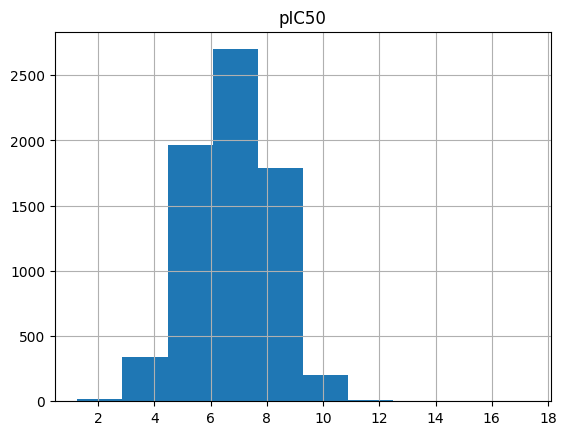

In [159]:
#Usando um histograma para avaliar

compounds_pIC50.hist(column="pIC50")

Vamos dar uma olhada nas estruturas dos compostos com maiores valores de pIC50

In [160]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(compounds_pIC50, smilesCol="Canonical_Smiles")

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,Molecule ChEMBL ID,Canonical_Smiles,pIC50,ROMol
6973,CHEMBL5073622,C=CC(=O)N1CC[C@H](Oc2nc(-c3n[nH]c(=O)[nH]3)cc3...,17.299989,
3681,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,
918,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,

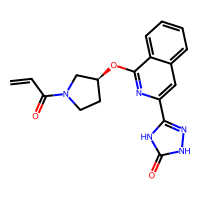
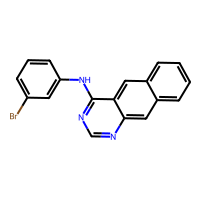
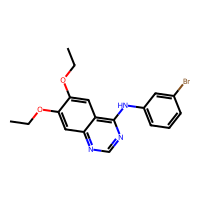

In [162]:
top_3_pIC50_values = compounds_pIC50.nlargest(3, 'pIC50')

top_3_pIC50_values

Como podemos resolver esse problema?

### 3.4) Filtro Ro5 (Rule of Five) de Lipinski

[<strong>Lead</strong> compounds](https://en.wikipedia.org/wiki/Lead_compound) are developmental drug candidates with promising properties. They are used as starting structures and modified with the aim to develop effective drugs. Besides bioactivity (_compound binds to the target of interest_), also favorable ADME properties are important criteria for the design of efficient drugs.

The bioavailability of a compound is an important ADME property. Lipinski's rule of five (Ro5, [<i>Adv. Drug Deliv. Rev.</i> (1997), <b>23</b>, 3-25](https://www.sciencedirect.com/science/article/pii/S0169409X96004231)) was introduced to estimate the bioavailability of a compound solely based on its chemical structure.
The Ro5 states that poor absorption or permeation of a compound is more probable if the chemical structure violates more than one of the following rules:

- Molecular weight (MWT) <= 500 Da
- Number of hydrogen bond acceptors (HBAs) <= 10
- Number of hydrogen bond donors (HBD) <= 5
- Calculated LogP (octanol-water coefficient) <= 5

Additional remarks:

- [LogP](https://en.wikipedia.org/wiki/Partition_coefficient) is also called partition coefficient or octanol-water coefficient. It measures the distribution of a compound, usually between a hydrophobic (e.g. 1-octanol) and a hydrophilic (e.g. water) phase.
- Hydrophobic molecules might have a reduced solubility in water, while more hydrophilic molecules (e.g. high number of hydrogen bond acceptors and donors) or large molecules (high molecular weight) might have more difficulties in passing phospholipid membranes.

In [140]:
def calculate_ro5_properties(smiles):
    """
    Testa se as moléculas de entrada (SMILES) obedecem a regra do 5.

    Parâmetros
    ----------
    smiles : str
        SMILES de uma molécula.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

A função calculate_ro5_properties pode ser aplicada ao nosso conjutno de dados para encontrar compostos que seguem a Ro5.

In [164]:
#Remover a coluna ROMol, não vamos utilizar mais.

compounds_pIC50.drop(columns=['ROMol'], inplace=True)

ro5_properties = compounds_pIC50["Canonical_Smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

<ipython-input-164-bbfd4f9a75cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds_pIC50.drop(columns=['ROMol'], inplace=True)


,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,529.164745,8,1,5.19038,False
1,378.216809,7,2,3.21102,True
2,428.132407,6,2,4.67470,True
3,386.085457,6,2,3.50440,True
4,300.001058,4,1,3.53090,True


Concatenando os dados das moléculas com os dados das Ro5

In [165]:
molecules = pd.concat([compounds_pIC50, ro5_properties], axis=1)
molecules.head()

,Molecule ChEMBL ID,Canonical_Smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL288441,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,6.308919,529.164745,8,1,5.19038,False
1,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,8.029979,378.216809,7,2,3.21102,True
2,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,8.070019,428.132407,6,2,4.67470,True
3,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,7.339989,386.085457,6,2,3.50440,True
4,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,6.160001,300.001058,4,1,3.53090,True


In [167]:
#criar dois dataframes um com os compostos que obedecem a Ro5 e um dos que não
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# Compostos no conjunto de dados antes da filtração: {molecules.shape[0]}")
print(f"# Compostos no conjunto de dados filtrados: {molecules_ro5_fulfilled.shape[0]}")
print(f"# Compostos que não obedecem a Ro5: {molecules_ro5_violated.shape[0]}")
# NBVAL_CHECK_OUTPUT

# Compostos no conjunto de dados antes da filtração: 7019
# Compostos no conjunto de dados filtrados: 5625
# Compostos que não obedecem a Ro5: 1394


In [173]:
molecules_ro5_fulfilled.head()

,Molecule ChEMBL ID,Canonical_Smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
1,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,8.029979,378.216809,7,2,3.21102,True
2,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,8.070019,428.132407,6,2,4.67470,True
3,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,7.339989,386.085457,6,2,3.50440,True
4,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,6.160001,300.001058,4,1,3.53090,True
5,CHEMBL405772,Cc1cccc(Nc2ncnc3ccncc23)c1N,7.389979,251.117095,5,2,2.65902,True


In [177]:
molecules_ro5_fulfilled.describe()

,pIC50,molecular_weight,n_hba,n_hbd,logp
count,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000
mean,6.683115,417.277980,6.099733,1.907733,4.043815
std,1.457500,88.850216,1.893175,1.010358,1.156140
min,1.259637,63.928045,0.000000,0.000000,-1.980000
25%,5.567031,355.063616,5.000000,1.000000,3.406600
50%,6.698970,421.193631,6.000000,2.000000,4.112100
75%,7.754487,481.168081,7.000000,3.000000,4.750300
max,17.299989,704.185617,11.000000,8.000000,8.782600


In [176]:
molecules_ro5_violated.describe()

,pIC50,molecular_weight,n_hba,n_hbd,logp
count,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000
mean,7.060639,591.146411,8.213773,2.179340,5.903185
std,1.261065,86.601564,2.111109,1.266149,1.305363
min,1.721246,450.116212,2.000000,0.000000,-4.968000
25%,6.154902,538.503140,7.000000,2.000000,5.310900
50%,7.187087,574.191773,8.000000,2.000000,5.814100
75%,7.958607,616.226553,9.000000,3.000000,6.550075
max,10.154902,1424.724290,19.000000,18.000000,13.116500


In [169]:
# Salvando o conjunto de dados filtrado
molecules_ro5_fulfilled.to_csv("EGFR_compounds_lipinski.csv")

,Molecule ChEMBL ID,Canonical_Smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
1,CHEMBL271410,Cc1cccc(Nc2ncnc3ccncc23)c1NCCCN1CCOCC1,8.029979,378.216809,7,2,3.21102,True
2,CHEMBL411243,CN(C)CCCCCNc1c(Br)cccc1Nc1ncnc2ccncc12,8.070019,428.132407,6,2,4.67470,True
3,CHEMBL270713,CN(C)CCNc1c(Br)cccc1Nc1ncnc2ccncc12,7.339989,386.085457,6,2,3.50440,True
4,CHEMBL54475,Brc1cccc(Nc2ncnc3ncccc23)c1,6.160001,300.001058,4,1,3.53090,True
5,CHEMBL405772,Cc1cccc(Nc2ncnc3ccncc23)c1N,7.389979,251.117095,5,2,2.65902,True


### 3.5) Filtro PAINS

#### **Unwanted Substructures**

Substructures can be unfavorable, e.g., because they are toxic or reactive, due to unfavorable pharmacokinetic properties, or because they likely interfere with certain assays.
Nowadays, drug discovery campaigns often involve [high throughput screening](https://en.wikipedia.org/wiki/High-throughput_screening). Filtering unwanted substructures can support assembling more efficient screening libraries, which can save time and resources.

Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 435-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)) have assembled a list of unfavorable substructures to filter their libraries used to screen for compounds to treat neglected diseases. Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive). This list of undesired substructures was published in the above mentioned paper and will be used in the practical part of this talktorial.

#### **Pan Assay Interference Compounds (PAINS)**

[PAINS](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds) are compounds that often occur as hits in HTS even though they actually are false positives. PAINS show activity at numerous targets rather than one specific target. Such behavior results from unspecific binding or interaction with assay components. Baell *et al.* ([_J. Med. Chem._ (2010), **53**, 2719-2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)) focused on substructures interfering in assay signaling. They described substructures which can help to identify such PAINS and provided a list which can be used for substructure filtering.

![PAINS](https://drive.google.com/uc?export=view&id=1c_fgudJzl6QyeJHZkRFiODDHLjoaWtr9)

Figure 1: Specific and unspecific binding in the context of PAINS. Figure taken from [Wikipedia](https://commons.wikimedia.org/wiki/File:PAINS_Figure.tif).

The PAINS filter is already implemented in RDKit ([documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html)). Such pre-defined filters can be applied via the `FilterCatalog` class. Let's learn how it can be used.

In [180]:
# Inicializando o filtro
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [188]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(molecules_ro5_fulfilled.iterrows(), total=molecules_ro5_fulfilled.shape[0]):
    molecule = Chem.MolFromSmiles(row['Canonical_Smiles'])
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row['Molecule ChEMBL ID'],
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = molecules_ro5_fulfilled.loc[clean]  # keep molecules without PAINS

  0%|          | 0/5625 [00:00<?, ?it/s]

In [189]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")

Number of compounds with PAINS: 498
Number of compounds without PAINS: 5127


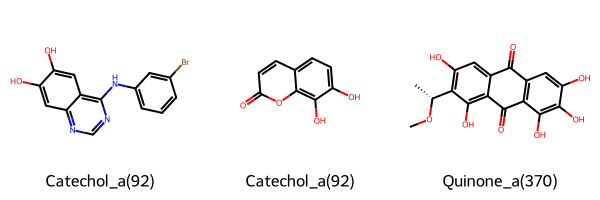

In [190]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

### 3.5) Análise exploratória de dados